## Data Preprocessing

In [280]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# load missing_indices from from the .npy file
missing_indices = np.load('../data/missing_indices.npy').tolist()

print("loaded omitted indices:", missing_indices)


loaded omitted indices: [2, 3, 4, 5, 9, 14, 18, 20, 22, 23]


#### Incorporating an Early RUL

We create the process_rul function because we also want to incorporate an early RUL, if specified. Early RUL is important because it allows for proactive maintenance decisions before a machine reaches its end of life, reducing the risk of unexpected failures and optimizing maintenance schedules. In many real world scenarios, repairs are conducted before complete failure. Therefore, the process_rul function is needed to generate RUL values that incorporate early warnings into the predictions. The early RUL provides an early warning that maintenance actions may be necessary before the machine fully reaches its end of life.

In [281]:
def process_rul(data_length, early_rul=None):
    
    # initialize empty list to store RUL values
    rul_values = []

    # if no early RUL is provided, fill with descending values from data_length - 1 to 0
    if early_rul is None:
        for i in range(data_length):
            rul_values.append(data_length - 1 - i)
    else:
        # get the duration for which early RUL is applicable
        early_rul_duration = data_length - early_rul
        
        # if early RUL duration is non-positive, return descending values same as when early_rul is None
        if early_rul_duration <= 0:
            for i in range(data_length):
                rul_values.append(data_length - 1 - i)
        else:
            # make the first rul_values to be the length of the early_rul_duration
            rul_values.extend([early_rul] * early_rul_duration)
            # make the remaining in descending values from early_rul - 1 to 0
            for i in range(early_rul):
                rul_values.append(early_rul - 1 - i)

    return np.array(rul_values)

In the example below when the early RUL is five and data length is 10, the first five values of the RUL are all five. This indicates that for the first five time cycles, the engine/unit is expected to last atleast five or more cycles. Here, the machine is monitored closely, and early warnings suggest it can still operate reliably. After the first five cycles, the RUL starts decreasing. As the machine continues to be used, its RUL diminishes and we simulate the wear and tear. In real world, knowing that the engine has early RUL of five can allow maintenance teams to take action before it reaches critical failure, for instance, schedule maintenance check/repair/replace parts after fifth cycle. 

In [282]:
early_rul_none = process_rul(10, early_rul = None)
early_rul_five = process_rul(10, early_rul = 5)
early_rul_fifteen = process_rul(10, early_rul = 15)

print("Examples for data length = 10")
print()
print("Early RUL is None:")
print(early_rul_none)
print()  
print("Early RUL is five:")
print(early_rul_five)
print()  
print("Early RUL is fifteen:")
print(early_rul_fifteen)
print()  

Examples for data length = 10

Early RUL is None:
[9 8 7 6 5 4 3 2 1 0]

Early RUL is five:
[5 5 5 5 5 4 3 2 1 0]

Early RUL is fifteen:
[9 8 7 6 5 4 3 2 1 0]



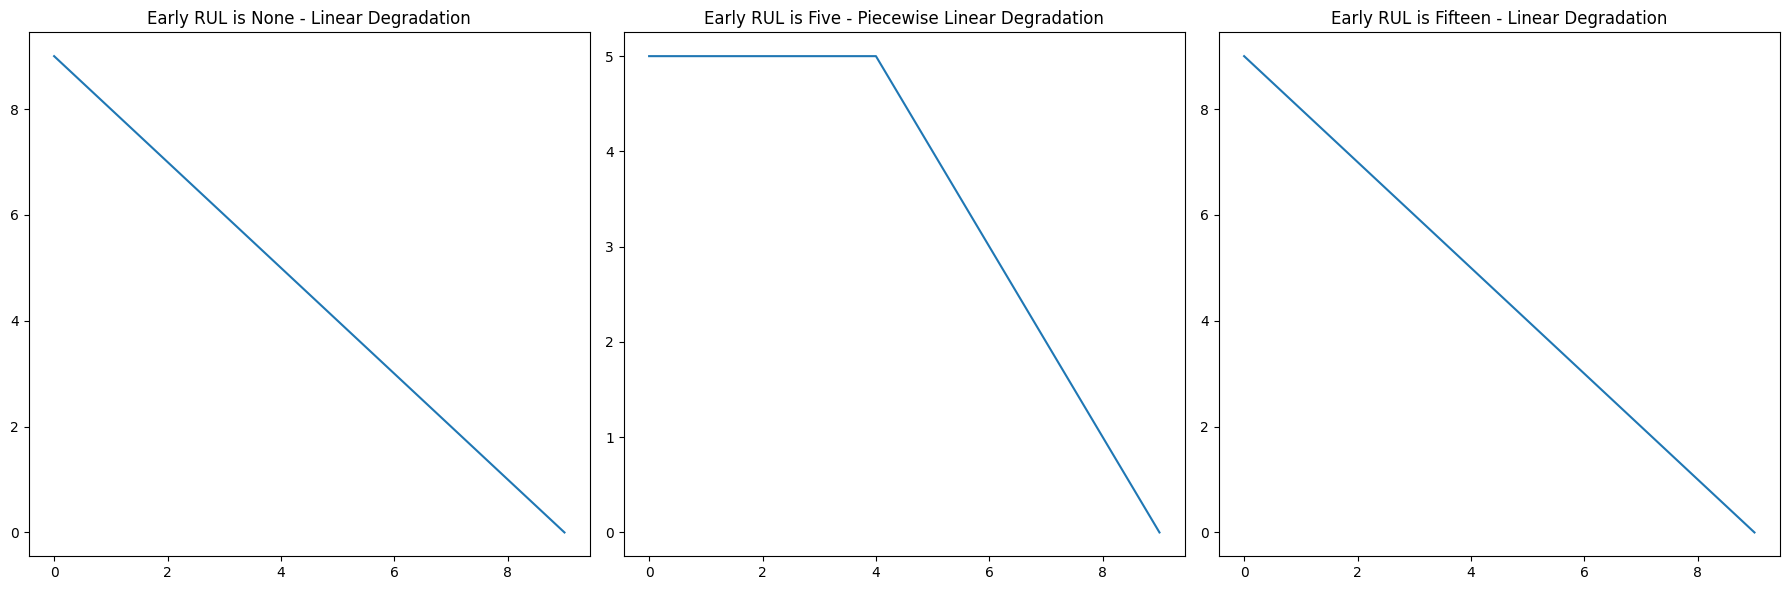

In [283]:
plt.figure(figsize=(18, 6))

plt.subplot(131) 
plt.plot(early_rul_none)
plt.title("Early RUL is None - Linear Degradation")

plt.subplot(132) 
plt.plot(early_rul_five)
plt.title("Early RUL is Five - Piecewise Linear Degradation")

plt.subplot(133) 
plt.plot(early_rul_fifteen)
plt.title("Early RUL is Fifteen - Linear Degradation")

plt.tight_layout() 
plt.show()

The pattern in the second image reflects real-world scenarios where machines may operate normally for a certain period (the early warning period) but then exhibit signs of wear that could lead to failure if not addressed. The constant early RUL allows for scheduled maintenance before reaching a critical point, helping to prevent unexpected repairs or safety events, in the case of jet engine failures.

### Function to Generate Batches Using Train/Test Data

The generate_data_batches_with_targets incorporates a window to the model in order to capture temporal patterns in the data. Each window will represent a fixed length sequence of data points which show the performance of the unit/engine over the specific period/window. The more recent the window, the more reflective it is of the future performance or failures. The window functionality will also allow us to analyze shorter segments of the unit/engine performance rather than the entire dataset at once. This level of granularity will allow the model to learn relevant features and trends because of the smaller windows we feed it, as opposed to being overwhelmed by excessive information and hence leadings to being unable to capture trends. 

In terms of the shifts incorporated using the function, the shifts allow for capturing overlapping windows which help to capture trends and changes more effectively. For instance, a shift of 1 means that each new window overlaps with the previous one by a single data point.
This overlap can help the model understand transitions in the data and improve its ability to make predictions based on recent changes. 

Finally, we are looking to create the batches because the batches are essential for efficient training of ML models. Instead of processing the entire dataset at once, which can be computationally expensive, we allow the processing of smaller batches which allow for quicker iterations. The training on batches will also help to sustain statistical stability. Each batch can provide a representative sample of the overall data distribution as opposed to forcing the model to memorize the entire dataset. 

The function also allows us to pair input windows with corresponding target values, if provided. The function prepares allows the model to learn to associate past data with future outcomes. For instance, if we have sensor X reading of 13.5, 13.3, 13.1 with RULs of 5, 4 and 3, then the model will pair sensor readings of 13.5, 13.3, 13.1 (assuming the window is 3 datapoints) with a final RUL of 3. Examples are provided below. 

In [284]:
# generate batches of data and targets from input_data and target_data based on specified window length and shift
# shift: no of steps to shift the window for the next batch
# window: length of each data window
# input data: all of our data from sensors, etc
# target data: RUL targers

def generate_data_batches_with_targets(input_data, target_data, window_length, shift):

    # calculate the number of batches that should be generated
    # calculates how many windows can be created from the input data by considering the total length of the data minus the window size
    # then divided by the shift, plus one for the last window hence ensuring that every possible sequence of the specified length is captured
    num_batches = int(np.floor((len(input_data) - window_length) / shift)) + 1
    num_features = input_data.shape[1]
    
    # empty array is initialized to hold the generated windows (batches of input data) which is filled with NaN values as a placeholder
    output_data = np.full((num_batches, window_length, num_features), np.nan)
    
    # loop iterates through each batch, calculating the starting and ending indices for each window based on the shift specified 
    # then extracts the actual data using indices and adds them to the output_data array
    for batch in range(num_batches):
        start_idx = shift * batch
        end_idx = start_idx + window_length
        output_data[batch] = input_data[start_idx:end_idx]
    
    if target_data is None:
        return output_data
    
    # create the output_targets
    output_targets = np.full(num_batches, np.nan)
    
    # fills the target array by selecting the RUL value at the end of each window
    # this enables the model to learn to predict the outcome based on the preceding data
    for batch in range(num_batches):
        target_index = shift * batch + (window_length - 1)
        output_targets[batch] = target_data[target_index]
    
    return output_data, output_targets

In [285]:
# to test the above function 

# generate demo data which has 5 time steps and 2 features
input_data = np.random.rand(5, 2)

# generate demo RUL data
target_data = np.maximum(0, 5 - np.arange(5))

# convert to df
input_df = pd.DataFrame(input_data, columns=['feature_1', 'feature_2'])
target_df = pd.Series(target_data, name='RUL')

# specify window length and shift 
window_length = 3
shift = 2

# apply the function 
output_data, output_targets = generate_data_batches_with_targets(input_data, target_data, window_length, shift)
print("input data")
print(input_df)
print()
print("output data")
print(output_data)
print()
print("target data")
print(target_data)
print("output targets")
print(output_targets)

input data
   feature_1  feature_2
0   0.552364   0.640245
1   0.116910   0.169933
2   0.894309   0.156111
3   0.312045   0.214232
4   0.628395   0.452004

output data
[[[0.55236374 0.64024451]
  [0.1169104  0.1699331 ]
  [0.89430924 0.1561111 ]]

 [[0.89430924 0.1561111 ]
  [0.31204548 0.21423246]
  [0.62839458 0.45200406]]]

target data
[5 4 3 2 1]
output targets
[3. 1.]


### Function to Generate Batches Using Test Data with Most Recent Data

In [286]:
# this function is very similar to generate batches function, however, if there are not enough batches to meet num_test_windows, 
# it adjusts the number of batches to the maximum possible and calculates the required length of data accordingly
# if sufficient batches are available, it calculates the required length based on num_test_windows.
# in summary: it prepares test data by creating batches from the end of the dataset

def batching_test_data(test_data, window_length, shift, num_test_windows):

    # get the maximum number of complete batches that can be created
    # calculates how many complete batches can be created from the test dataset based on the specified window length and shift
    max_num_batches = (len(test_data) - window_length) // shift + 1

    # determine the required length of data based on the number of requested test windows
    if max_num_batches < num_test_windows:
        # if not enough batches, adjust to the maximum possible
        required_len = (max_num_batches - 1) * shift + window_length
        extracted_num_test_windows = max_num_batches
    else:
        # if enough batches are available, calculate based on requested num_test_windows
        required_len = (num_test_windows - 1) * shift + window_length
        extracted_num_test_windows = num_test_windows

    # gets the most recent data points from the test dataset, focusing on the last required_len entries
    # which is important for predicting future outcomes based on the latest data available
    # then uses the generate_data_batches_with_targets function to structure this data into windows
    batched_test_data = generate_data_batches_with_targets(
        test_data[-required_len:, :],  # take the last 'required_len' --- will always create windows from the bottom/most recent
        target_data=None,              # no target data for test processing
        window_length=window_length,    
        shift=shift)

    return batched_test_data, extracted_num_test_windows

In [287]:
# to test the above function

# demo 2D array with 10 samples and 2 features
test_data = np.reshape(np.arange(15), newshape = (5,3))

# define params
window_length = 2    # length of each batch
shift = 1            # step size of window
num_test_windows = 3 # no of test samples to extract

# call process
batched_test_data, extracted_num_test_windows = batching_test_data(test_data, window_length, shift, num_test_windows)

print("test data")
print(test_data)
print()
print("batched test data:")
print(batched_test_data)
print()
print("extracted num of test windows:")
print(extracted_num_test_windows)

test data
[[ 0  1  2]
 [ 3  4  5]
 [ 6  7  8]
 [ 9 10 11]
 [12 13 14]]

batched test data:
[[[ 3.  4.  5.]
  [ 6.  7.  8.]]

 [[ 6.  7.  8.]
  [ 9. 10. 11.]]

 [[ 9. 10. 11.]
  [12. 13. 14.]]]

extracted num of test windows:
3


### Define Additional Functions to Finalize Data Preprocessing

In [288]:
from sklearn.preprocessing import StandardScaler

# set parameters
window_length = 30
shift = 1
early_rul_threshold = 125
num_test_windows = 1
columns_to_drop = [0, 1] + missing_indices

# load the datasets into one function which outputs the train, test, and true RUL
def load_datasets():
    train_data = pd.read_csv("../data/CMAPSSData/train_FD001.txt", sep="\s+", header=None)
    test_data = pd.read_csv("../data/CMAPSSData/test_FD001.txt", sep="\s+", header=None)
    true_rul = pd.read_csv("../data/CMAPSSData/RUL_FD001.txt", sep='\s+', header=None)
    return train_data, test_data, true_rul

# scale the dataset, preserving the first column (unit number)
def scale_dataset(df):
    # initialize the scaler
    scaler = StandardScaler()
    # apply the scaler to the columns in the df that only need scaling and drop the ones that we needed to drop from earlier
    scaled_features = scaler.fit_transform(df.drop(columns=columns_to_drop))
    # add back the unit_number/engine back to the scaled features df 
    return pd.DataFrame(data=np.c_[df[0], scaled_features])

In [289]:
# the process_train_data function transforms raw data into structured input-output pairs which will help in our ML models
# it processes data for each unit separately and generates corresponding RUL targets (see examples above for how it works) 
# it also ensures sufficient data for window creation, all of which help to learn temporal patterns
# below, we process each engine's/unit_numbers data to prepare for training

def process_train_data(train_df, window_length, shift):
    processed_train_data, processed_train_targets = [], []
    for unit_number in range(1, train_df[0].nunique() + 1):
        # filter dataset for the current unit/engine and drop the unit number column itself since we just filtered that data alone
        unit_specific_data = train_df[train_df[0] == unit_number].drop(columns=[0]).values

        # validate that there is enough data for window length
        if len(unit_specific_data) < window_length:
            raise ValueError(f"unit {unit_number} doesn't have enough data for window_length of {window_length}")

        # process targets and generate data batches
        target_values = process_rul(data_length=unit_specific_data.shape[0], early_rul=early_rul_threshold)
        # generate the batches from the data alongside their corresponding target values
        train_processed_unit_data, train_processed_unit_targets = generate_data_batches_with_targets(unit_specific_data, target_values, window_length=window_length, shift=shift)
        
        # append the unit data and targets to the dictionary
        processed_train_data.append(train_processed_unit_data)
        processed_train_targets.append(train_processed_unit_targets)
    
    return np.concatenate(processed_train_data), np.concatenate(processed_train_targets)

In [290]:
# similar to above, it processes the test data for each unit/engine

def process_test_data(test_df, window_length, shift, num_test_windows):
    processed_test_data = []
    for unit_number in range(1, test_data[0].nunique() + 1):
        # filter dataset for the current unit/engine
        unit_specific_test_data = test_df[test_df[0] == unit_number].drop(columns=[0]).values

        # validate enough data for window length
        if len(unit_specific_test_data) < window_length:
            raise ValueError(f"unit {unit_number} doesn't have enough data for window_length of {window_length}")

        # prepare the test data per unit and then append to the batch dictionary for test data
        test_processed_unit_data, num_batches = batching_test_data(unit_specific_test_data, window_length=window_length, shift=shift, num_test_windows=num_test_windows)
        processed_test_data.append(test_processed_unit_data)
    
    # we only generate the test_data_batches because the actual targets are given to us in the true RUL. we use our ML model to train on the training
    # dataset, then, we test and predict what it would be like on the test dataset/test_data_batches, and then compare our predictions against true RUL
    return np.concatenate(processed_test_data)

In [291]:
# shuffling function so we can significantly improve the robustness and reliability of the model's training process
# without shuffling, the model may learn to recognize patterns that are only valid in the specific sequnence rather than capturing broader relationships
# especially when batching, shuffling ensures that each batch contains a mix of examples and helps maintain the statisitcal proporties of the df

def shuffle_training_data(train_data, train_targets):
    """shuffle the training data and targets"""
    shuffled_indices = np.random.permutation(len(train_targets))
    return train_data[shuffled_indices], train_targets[shuffled_indices]

### Smoothing Function

In [ ]:
from supersmoother import SuperSmoother


def supersmooth(df):
    smoothed_df = pd.DataFrame()

    # iterate over each unit_number
    for unit_number in df[0].unique():
        unit_df = df[df[0] == unit_number].drop_duplicates(subset=[1])  # Remove duplicate time cycles
        unit_smoothed_df = pd.DataFrame()
        unit_smoothed_df[0] = unit_df[0]  # unit_number
        unit_smoothed_df[1] = unit_df[1]  # time_cycles

        # get sensor columns which are starting from index 2
        sensor_cols = unit_df.columns[2:]

        # apply smoother to each sensor column
        for sensor in sensor_cols:
            print(str(sensor) +  " for Unit " + str(unit_number))
            smoother = SuperSmoother()  
            smoother.fit(unit_df[1], unit_df[sensor])  # Use index 1 for time_cycles
            unit_smoothed_df[sensor] = smoother.predict(unit_df[1])  # use index 1 for time_cycles

        smoothed_df = pd.concat([smoothed_df, unit_smoothed_df], ignore_index=True)

    return smoothed_df

#### Preprocess the Train and Test Data

In [293]:
# load dataframes
train_data, test_data, true_rul = load_datasets()

# apply smoothing to the datasets
smoothed_train_data = supersmooth(train_data)
smoothed_test_data = supersmooth(test_data)

# scale the smoothed datasets
scaled_train_data = scale_dataset(smoothed_train_data)
scaled_test_data = scale_dataset(smoothed_test_data)

# process and finalize training data to send into the model
train_data_batches, train_target_values = process_train_data(scaled_train_data, window_length, shift)

# process and finalize test data to send into the model
test_data_batches = process_test_data(scaled_test_data, window_length, shift, num_test_windows)

# obtain true RUL values
true_rul_values = true_rul[0].values  

# shuffle training data
train_data_batches, train_target_values = shuffle_training_data(train_data_batches, train_target_values)

print("Processed training data shape: ", train_data_batches.shape)
print("Processed training RUL shape: ", train_target_values.shape)
print("Processed test data shape: ", test_data_batches.shape)
print("True RUL shape: ", true_rul_values.shape)


2 for Unit 1
3 for Unit 1
4 for Unit 1
5 for Unit 1
6 for Unit 1
7 for Unit 1
8 for Unit 1
9 for Unit 1
10 for Unit 1
11 for Unit 1
12 for Unit 1
13 for Unit 1
14 for Unit 1
15 for Unit 1
16 for Unit 1
17 for Unit 1
18 for Unit 1
19 for Unit 1
20 for Unit 1
21 for Unit 1
22 for Unit 1
23 for Unit 1
24 for Unit 1
25 for Unit 1
2 for Unit 2
3 for Unit 2
4 for Unit 2
5 for Unit 2
6 for Unit 2
7 for Unit 2
8 for Unit 2
9 for Unit 2
10 for Unit 2
11 for Unit 2
12 for Unit 2
13 for Unit 2
14 for Unit 2
15 for Unit 2
16 for Unit 2
17 for Unit 2
18 for Unit 2
19 for Unit 2
20 for Unit 2
21 for Unit 2
22 for Unit 2
23 for Unit 2
24 for Unit 2
25 for Unit 2
2 for Unit 3
3 for Unit 3
4 for Unit 3
5 for Unit 3
6 for Unit 3
7 for Unit 3
8 for Unit 3
9 for Unit 3
10 for Unit 3
11 for Unit 3
12 for Unit 3
13 for Unit 3
14 for Unit 3
15 for Unit 3
16 for Unit 3
17 for Unit 3
18 for Unit 3
19 for Unit 3
20 for Unit 3
21 for Unit 3
22 for Unit 3
23 for Unit 3
24 for Unit 3
25 for Unit 3
2 for Unit 4
3 f

ValueError: Zero denominator in linear smooth. This usually indicates that the input contains duplicate points.

### Saving the Data

In [ ]:
import os
import pickle

# create a new directory for processed data
output_dir = '../data/processed_data_pickle_files_with_smoothing'
os.makedirs(output_dir, exist_ok=True)  # creates the directory if it doesn't exist

# save processed data  directory
with open(os.path.join(output_dir, 'train_data_batches.pkl'), 'wb') as f:
    pickle.dump(train_data_batches, f)

with open(os.path.join(output_dir, 'train_target_values.pkl'), 'wb') as f:
    pickle.dump(train_target_values, f)

with open(os.path.join(output_dir, 'test_data_batches.pkl'), 'wb') as f:
    pickle.dump(test_data_batches, f)

with open(os.path.join(output_dir, 'true_rul_values.pkl'), 'wb') as f:
    pickle.dump(true_rul_values, f)

with open(os.path.join(output_dir, 'train_data_no_batches.pkl'), 'wb') as f:
    pickle.dump(smoothed_train_data, f)

with open(os.path.join(output_dir, 'test_data_no_batches.pkl'), 'wb') as f:
    pickle.dump(smoothed_test_data, f)



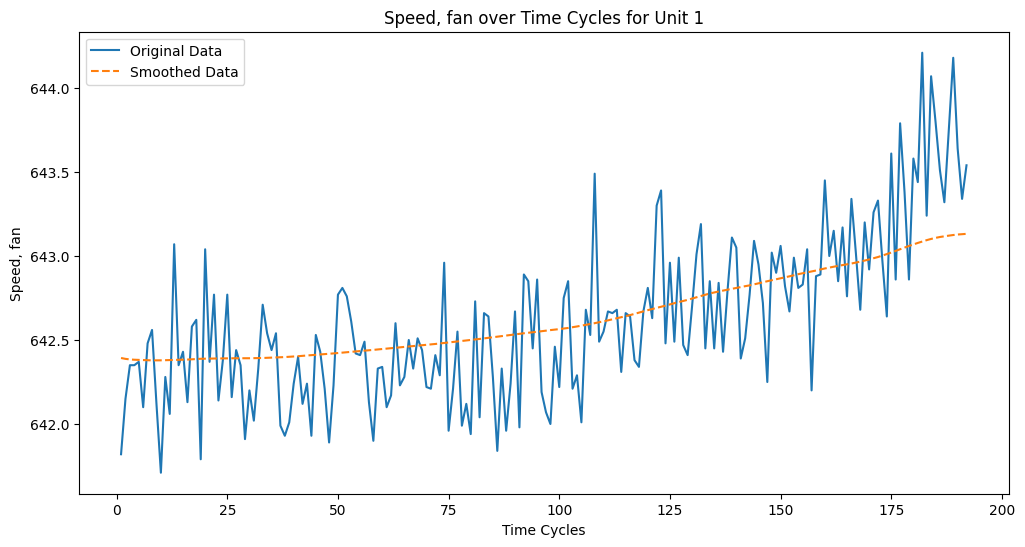

In [ ]:
# Define the column index for 'Speed, fan'
speed_fan_index = 6  # Assuming 'Speed, fan' is the 7th column (0-based index)

# Filter data for a specific unit number, e.g., unit 1
unit_number = 1
train_unit_data = train_data[train_data[0] == unit_number]
smoothed_train_unit_data = smoothed_train_data[smoothed_train_data[0] == unit_number]

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(train_unit_data[1], train_unit_data[speed_fan_index], label='Original Data')
plt.plot(smoothed_train_unit_data[1], smoothed_train_unit_data[speed_fan_index], label='Smoothed Data', linestyle='--')
plt.xlabel('Time Cycles')
plt.ylabel('Speed, fan')
plt.title('Speed, fan over Time Cycles for Unit 1')
plt.legend()
plt.show()